In [133]:
import numpy as np
from keras.datasets import mnist
import keras
import tensorflow as tf
from keras import backend as K

import matplotlib.pyplot as plt
plt.gray()
%matplotlib inline

# Fooling a MNIST Classifier
In this notebook I explore how to generate images that visually appear to be of one class, but are classified as a different class by the simple CNN trained earlier. I focus my attention to a single image, a three, and try to come up with something that appears similar, but is classified as an eight. I approach this several different ways below.

In [225]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train[..., None] / 255.0
x_test = x_test[..., None] / 255.0
ex = x_train[44] #to distort into an 8
ex2 = x_train[1]

Text(0.5,1,'True Class: 3')

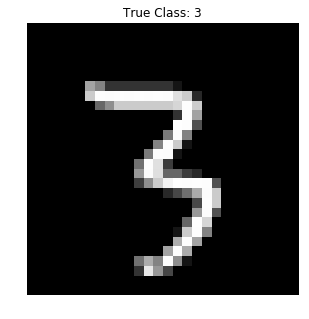

In [270]:
plt.figure(figsize=(5, 5))
plt.subplot(1, 1, 1)
plt.imshow(ex.reshape(28, 28))
plt.axis('off')
plt.title('True Class: 3')

# plt.subplot(1, 2, 2)
# plt.imshow(ex2.reshape(28, 28))
# plt.axis('off')
# plt.title('True Class: 0')

In [115]:
model = keras.models.load_model('./simple_cnn.h5')

In [116]:
try:
    while True:
        tf.get_default_session().close()
except: pass
sess = K.get_session()
# K.set_learning_phase(0)

In [118]:
x = model.input
y = model.output

### Original predictions for example image (99.9999% confidence)

In [320]:
sess.run(y, feed_dict={x:ex[None]})[0]

array([2.2452619e-13, 3.1456726e-10, 8.6283503e-10, 9.9999857e-01,
       8.0937034e-14, 8.5810917e-08, 5.2202611e-13, 1.3150121e-06,
       1.2142451e-08, 4.2050838e-09], dtype=float32)

In [293]:
target_grad = np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0,], dtype=np.float32)[None]
zeroness = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0,], dtype=np.float32)[None]
target_2 = np.array([0, 0, 0, -1, 0, 0, 0, 1, 0, 0,], dtype=np.float32)[None]

In [294]:
int_grad = tf.gradients(y, x, target_grad)
zeroness = tf.gradients(y, x, zeroness)
diff_grad = tf.gradients(y, x, target_2)

## How much change is needed to be misclassified?
Below is the simplest example of adversarial image generation. Here, I set the target class of the image to be 8, and run a forward step. Then, I run backpropagation (but do not update the weights) to get $dL/dx$, where $x$ is the input to the model, and loss is the loss measured between the predicted output of the model and the target class (8 in this case). We can then perform gradient descent on only $x$ to try to minimize the loss, meaning after each iteration, we update the image $x$ to better match the desired class. 

Below, we can see the results of this process. With barely any modification, an image that still very much appears to be a three is classified as an eight.

In [315]:
eps = 1e3
ints = []
tmp = ex.copy()[None]
i = 0
while i<2000 and (sess.run(y, feed_dict={x:tmp})[0, 7]<0.9):
    tmp += eps*sess.run(int_grad, feed_dict={x:tmp})[0]
    if sess.run(y, feed_dict={x:tmp})[0, 7] > 1e-4:
        eps = 1e-1
    tmp = np.clip(tmp, 0, 1)
    i += 1

In [318]:
np.round(sess.run(y, feed_dict={x:tmp})[0], 3)

array([0.   , 0.   , 0.   , 0.096, 0.   , 0.   , 0.   , 0.903, 0.   ,
       0.   ], dtype=float32)

(-0.5, 27.5, 27.5, -0.5)

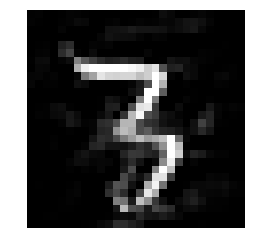

In [316]:
plt.imshow(tmp[0, ..., 0])
plt.axis('off')

## What if we only set some pixels to be 1
It would be interesting to see how the above result changes if we constrain our modifications to be setting pixels to be 1. We can see below that the example generated is classified as an eight, and looks like half of a three, and half of an eight. If we chose pixel values outside the range $[0, 1]$, we would only need to change one pixel to get a misclassification.

In [272]:
eps = 1e3
ints = []
tmp = ex.copy()[None]
i = 0
while i<20 and (sess.run(y, feed_dict={x:tmp}).argmax() != 7):
    ps = sess.run(diff_grad, feed_dict={x:tmp})[0] * (tmp!=1)
    ixx = np.unravel_index(ps.argmax(), (28, 28))
    tmp[:, ixx[0], ixx[1]] = 1.0
#     if sess.run(y, feed_dict={x:tmp})[0, 7] > 1e-4:
#         eps = 1e-1
#     tmp = np.clip(tmp, 0, 1)
    i += 1

(-0.5, 27.5, 27.5, -0.5)

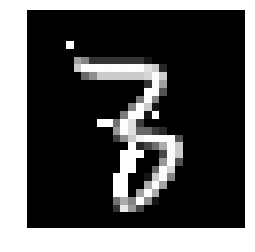

In [273]:
plt.imshow(tmp[0, ..., 0])
plt.axis('off')

In [274]:
np.round(sess.run(y, feed_dict={x:tmp})[0], 3) # prediction probabilities for above image

array([0.   , 0.   , 0.003, 0.328, 0.   , 0.   , 0.   , 0.614, 0.055,
       0.   ], dtype=float32)

## What image could have the most "zeroness" possible?
We can try to come up with something that maximizes the probability of a class like we did above, setting the gradient for $y=0$ to be 1, and propagating that through to see what the corresponding derivative $dy/dx$ is.

In [311]:
eps = 1e-1
ints = []
tmp = np.zeros((1, 28, 28, 1))
i = 0
while i<2000 and (sess.run(y, feed_dict={x:tmp})[0, 0] < 0.9999):
    tmp += eps*sess.run(zeroness, feed_dict={x:tmp})[0]
#     if sess.run(y, feed_dict={x:tmp})[0, 7] > 1e-4:
#         eps = 1e-1
    tmp = np.clip(tmp, 0, 1)
    i += 1

In [312]:
np.round(sess.run(y, feed_dict={x:tmp})[0], 3) # prediction probabilities for above image

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

(-0.5, 27.5, 27.5, -0.5)

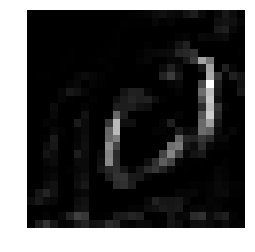

In [314]:
plt.imshow(tmp[0, ..., 0])
plt.axis('off')

This sort of looks like a zero, but not really. This indicates one of the weaknesses of neural networks; they will always output a class label, and even things that don't seem very much like an item can be classified in a category.